In [1]:
import os
import glob
from pathlib import Path
import json
import numpy as np
import nussl
import torch
from nussl.datasets import transforms as nussl_tfm
from common import utils, argbind
import matplotlib.pyplot as plt
from nussl.ml.networks.modules import AmplitudeToDB, BatchNorm, RecurrentStack, Embedding
from nussl.separation.base import MaskSeparationBase, DeepMixin, SeparationException
from torch import nn
# from torch.nn.utils import weight_norm
from ignite.engine import Events, Engine, EventEnum
from nussl.ml import SeparationModel
from nussl.ml.networks.modules import (
    Embedding, DualPath, DualPathBlock, STFT, Concatenate, 
    LearnedFilterBank, AmplitudeToDB, RecurrentStack,
    MelProjection, BatchNorm, InstanceNorm, ShiftAndScale
)
from torch import optim
import sys

sys.path.append("../../")
from setup_al3625 import *

In [2]:
utils.logger()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

name = os.getcwd().split("/")[-1]

eval_folder = "../../eval_results"
output_folder = os.path.join("../../trained_models", name)
results_folder = os.path.join(eval_folder, name)
separator_folder = os.path.join("../../trained_models", name, "separator")

saved_model_best = os.path.join(output_folder, "checkpoints/best.model.pth")
saved_model_new = os.path.join(output_folder, "checkpoints/latest.model.pth")
saved_opt_best = os.path.join(output_folder, "checkpoints/best.optimizer.pth")
saved_opt_new = os.path.join(output_folder, "checkpoints/latest.optimizer.pth")
saved_separator = os.path.join(separator_folder, "separator.model.pth")

if not os.path.exists(output_folder):
    os.mkdir(output_folder)
if not os.path.exists(eval_folder):
    os.mkdir(eval_folder)
if not os.path.exists(results_folder):
    os.mkdir(results_folder)
if not os.path.exists(separator_folder):
    os.mkdir(separator_folder)

In [3]:
EPOCHS = 50          
BATCH_SIZE = 8 
LEARNING_RATE = 1e-3 

stft_params = nussl.STFTParams(window_length=512, hop_length=128)
nf = stft_params.window_length // 2 + 1
# corpus = get_corpus([full_train_folder, val_folder, test_folder])

In [4]:
class PosteriorModel(nn.Module):
    def __init__(self, num_features, num_audio_channels, hidden_size,
                 num_layers, bidirectional, dropout, num_sources, 
                activation='sigmoid'):
        super().__init__()

        self.recurrent_stack = RecurrentStack(
            41, hidden_size, 
            num_layers, bool(bidirectional), dropout, 'lstm'
        )

        hidden_size = hidden_size * (int(bidirectional) + 1)
        self.embedding = Embedding(num_features, hidden_size, 
                                   num_sources, activation, 
                                   num_audio_channels)
        
    def forward(self, mix_magnitude, posterior):

        stack_data = self.recurrent_stack(posterior)
        mask = self.embedding(stack_data)
        estimates = mix_magnitude.unsqueeze(-1) * mask
        
        output = {
            'mask': mask,
            'estimates': estimates
        }
        return output
        
    @staticmethod
    @argbind.bind_to_parser()
    def build(num_features, num_audio_channels, hidden_size, 
              num_layers, bidirectional, dropout, num_sources, 
              activation='sigmoid'):
        nussl.ml.register_module(PosteriorModel)
        modules = {
            'model': {
                'class': 'PosteriorModel',
                'args': {
                    'num_features': num_features,
                    'num_audio_channels': num_audio_channels,
                    'hidden_size': hidden_size,
                    'num_layers': num_layers,
                    'bidirectional': bidirectional,
                    'dropout': dropout,
                    'num_sources': num_sources,
                    'activation': activation
                }
            }
        }
        connections = [
            ['model', ['mix_magnitude', 'posterior']]
        ]
        for key in ['mask', 'estimates']:
            modules[key] = {'class': 'Alias'}
            connections.append([key, [f'model:{key}']])
        output = ['estimates', 'mask',]
        config = {
            'name': 'PosteriorModel',
            'modules': modules,
            'connections': connections,
            'output': output
        }
        return nussl.ml.SeparationModel(config)

In [5]:
keys = ["posterior"]
post_depth=False
use_corpus=False
train_data, val_data, test_data = get_data("../../", post_depth=post_depth, keys=keys, use_corpus=use_corpus)

In [6]:
model = PosteriorModel.build(num_features=nf,
                            num_audio_channels=1, 
                            hidden_size=256,
                            num_layers=3,
                            bidirectional=True, 
                            dropout=0.3, 
                            num_sources=1, 
                            activation='sigmoid')

if os.path.exists(saved_model_new):
    model_checkpoint = torch.load(saved_model_new)
    model = SeparationModel(model_checkpoint["config"]) 
    model.load_state_dict(model_checkpoint["state_dict"])
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    optimizer_checkpoint =  torch.load(saved_opt_new)
    optimizer.load_state_dict(optimizer_checkpoint)

else:
    model = PosteriorModel.build(num_features=nf,
                             num_audio_channels=1, 
                             hidden_size=256,
                             num_layers=3,
                             bidirectional=True, 
                             dropout=0.3, 
                             num_sources=1, 
                             activation='sigmoid')
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [7]:
loss_fn = nussl.ml.train.loss.L1Loss()

def train_step(engine, batch):
    optimizer.zero_grad()
    output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )
    loss.backward() # backwards + gradient step
    optimizer.step()
    loss_vals = {
        'L1Loss': loss.item(),
        'loss': loss.item()
    }
    return loss_vals

def val_step(engine, batch):
    with torch.no_grad():
        output = model(data=batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )
    loss_vals = {
        'L1Loss': loss.item(),
        'loss': loss.item()
    }
    return loss_vals

In [8]:
train_dataloader = torch.utils.data.DataLoader(
    train_data, num_workers=4, batch_size=BATCH_SIZE)
val_dataloader = torch.utils.data.DataLoader(
    val_data, num_workers=4, batch_size=BATCH_SIZE) 

trainer, validator = modified_create_train_and_validation_engines(
    train_step, val_step, device=DEVICE
)
nussl.ml.train.add_stdout_handler(trainer, validator)
nussl.ml.train.add_validate_and_checkpoint(output_folder, model,
    optimizer, train_data, trainer, val_dataloader, validator)
nussl.ml.train.add_progress_bar_handler(trainer, validator)

if os.path.exists(saved_model_new):
    trainer.load_state_dict(model_checkpoint["metadata"]["trainer.state_dict"])
    trainer.state.epoch_history = model_checkpoint["metadata"]["trainer.state.epoch_history"]

05/08/2023 08:15:12 PM | engine.py:874 Engine run starting with max_epochs=50.


[1/75]   1%|1          [00:00<?]

05/08/2023 08:30:02 PM | engine.py:874 Engine run starting with max_epochs=1.


[1/2]  50%|#####      [00:00<?]

05/08/2023 08:31:26 PM | engine.py:972 Epoch[1] Complete. Time taken: 00:01:23.867
05/08/2023 08:31:26 PM | engine.py:988 Engine run complete. Time taken: 00:01:24.014
05/08/2023 08:31:27 PM | trainer.py:311 

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0001 / 0050 
- Training loss:   0.000468 
- Validation loss: 0.000450 
- Epoch took: 0:16:14.913955 
- Time since start: 0:16:14.914006 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to ../../trained_models/all_post_2/checkpoints/best.model.pth. 
Output @ ../../trained_models/all_post_2 



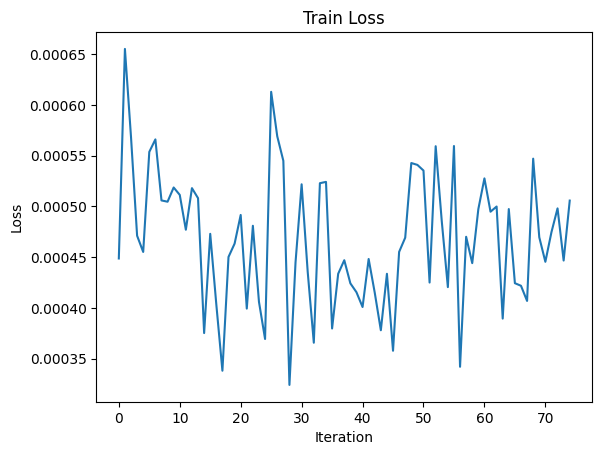

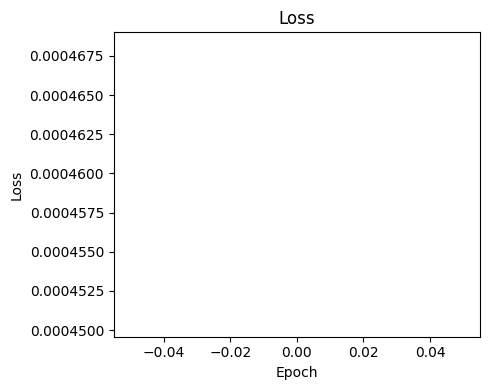

05/08/2023 08:31:27 PM | engine.py:972 Epoch[1] Complete. Time taken: 00:16:15.370


[1/75]   1%|1          [00:00<?]

05/08/2023 08:44:56 PM | engine.py:874 Engine run starting with max_epochs=1.


[1/2]  50%|#####      [00:00<?]

05/08/2023 08:46:16 PM | engine.py:972 Epoch[1] Complete. Time taken: 00:01:20.187
05/08/2023 08:46:16 PM | engine.py:988 Engine run complete. Time taken: 00:01:20.339
05/08/2023 08:46:17 PM | trainer.py:311 

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0002 / 0050 
- Training loss:   0.000456 
- Validation loss: 0.000405 
- Epoch took: 0:14:49.984710 
- Time since start: 0:31:05.501518 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to ../../trained_models/all_post_2/checkpoints/best.model.pth. 
Output @ ../../trained_models/all_post_2 



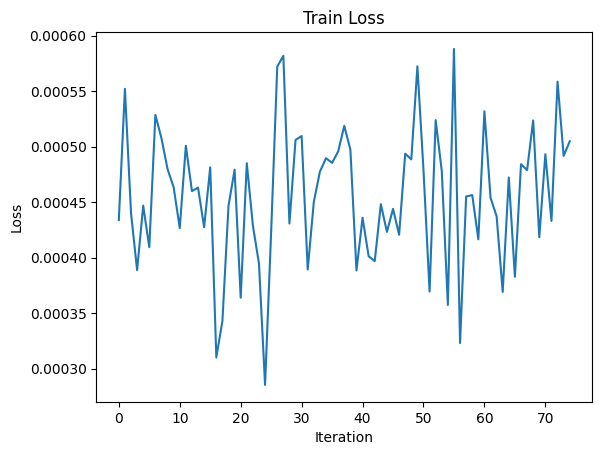

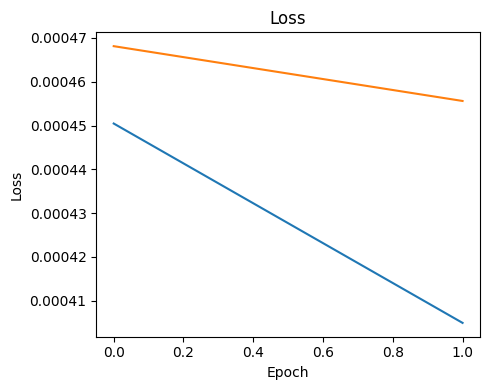

05/08/2023 08:46:18 PM | engine.py:972 Epoch[2] Complete. Time taken: 00:14:50.444


[1/75]   1%|1          [00:00<?]

05/08/2023 08:59:54 PM | engine.py:874 Engine run starting with max_epochs=1.


[1/2]  50%|#####      [00:00<?]

05/08/2023 09:01:14 PM | engine.py:972 Epoch[1] Complete. Time taken: 00:01:20.296
05/08/2023 09:01:14 PM | engine.py:988 Engine run complete. Time taken: 00:01:20.455
05/08/2023 09:01:15 PM | trainer.py:311 

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0003 / 0050 
- Training loss:   0.000450 
- Validation loss: 0.000405 
- Epoch took: 0:14:57.044693 
- Time since start: 0:46:03.006103 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to ../../trained_models/all_post_2/checkpoints/latest.model.pth. 
Output @ ../../trained_models/all_post_2 



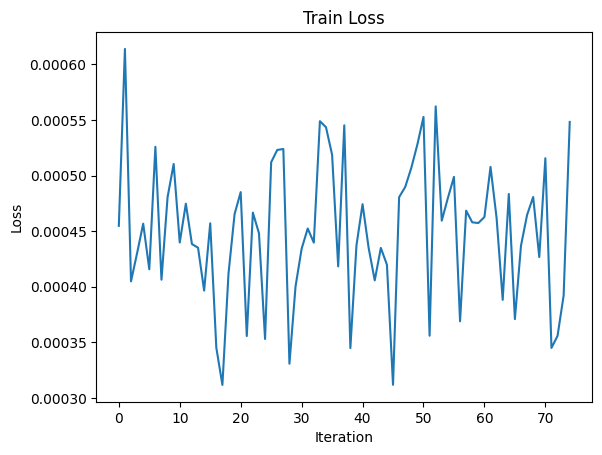

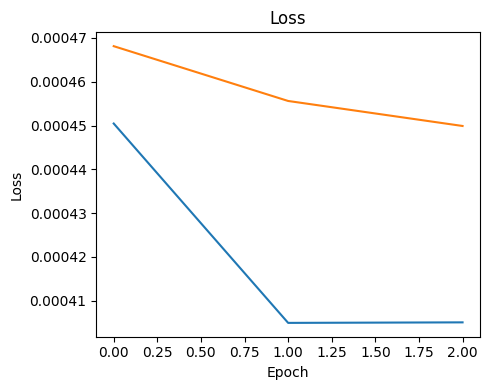

05/08/2023 09:01:15 PM | engine.py:972 Epoch[3] Complete. Time taken: 00:14:57.523


[1/75]   1%|1          [00:00<?]

05/08/2023 09:14:53 PM | engine.py:874 Engine run starting with max_epochs=1.


[1/2]  50%|#####      [00:00<?]

05/08/2023 09:16:14 PM | engine.py:972 Epoch[1] Complete. Time taken: 00:01:20.399
05/08/2023 09:16:14 PM | engine.py:988 Engine run complete. Time taken: 00:01:20.553
05/08/2023 09:16:14 PM | trainer.py:311 

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0004 / 0050 
- Training loss:   0.000450 
- Validation loss: 0.000455 
- Epoch took: 0:14:59.147460 
- Time since start: 1:01:02.632535 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to ../../trained_models/all_post_2/checkpoints/latest.model.pth. 
Output @ ../../trained_models/all_post_2 



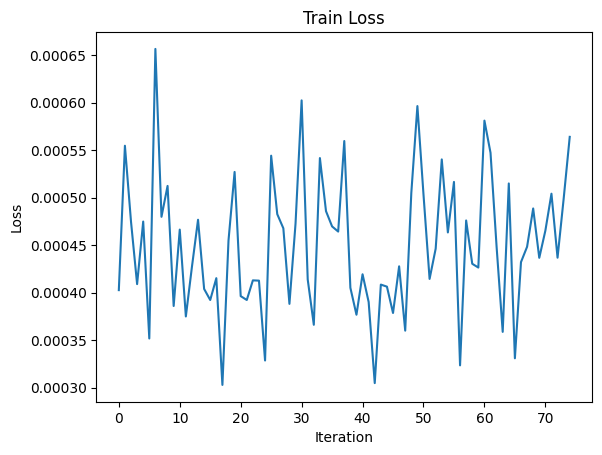

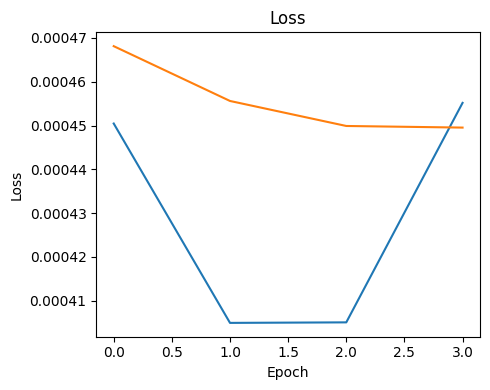

05/08/2023 09:16:15 PM | engine.py:972 Epoch[4] Complete. Time taken: 00:14:59.650


[1/75]   1%|1          [00:00<?]

05/08/2023 09:29:25 PM | engine.py:874 Engine run starting with max_epochs=1.


[1/2]  50%|#####      [00:00<?]

05/08/2023 09:30:46 PM | engine.py:972 Epoch[1] Complete. Time taken: 00:01:20.322
05/08/2023 09:30:46 PM | engine.py:988 Engine run complete. Time taken: 00:01:20.472
05/08/2023 09:30:46 PM | trainer.py:311 

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0005 / 0050 
- Training loss:   0.000455 
- Validation loss: 0.000513 
- Epoch took: 0:14:31.354101 
- Time since start: 1:15:34.490535 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to ../../trained_models/all_post_2/checkpoints/latest.model.pth. 
Output @ ../../trained_models/all_post_2 



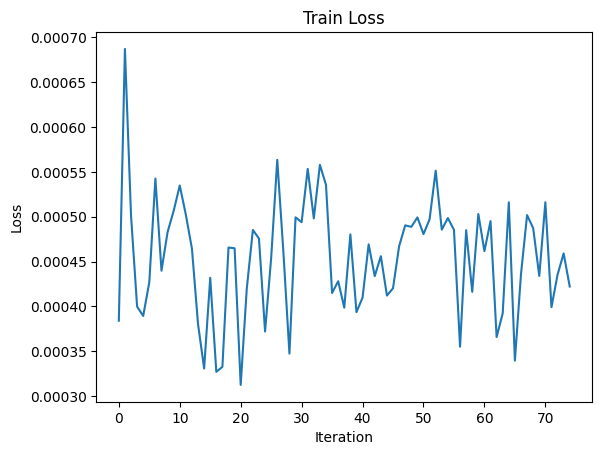

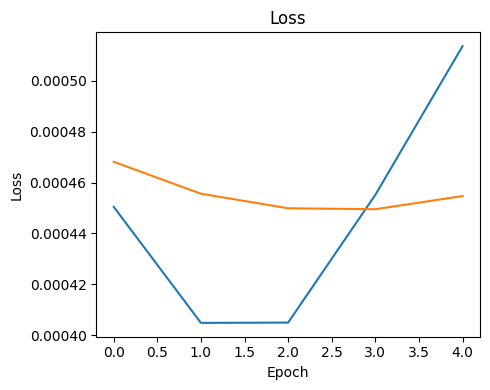

05/08/2023 09:30:47 PM | engine.py:972 Epoch[5] Complete. Time taken: 00:14:31.836


[1/75]   1%|1          [00:00<?]

05/08/2023 09:43:58 PM | engine.py:874 Engine run starting with max_epochs=1.


[1/2]  50%|#####      [00:00<?]

05/08/2023 09:45:17 PM | engine.py:972 Epoch[1] Complete. Time taken: 00:01:18.528
05/08/2023 09:45:17 PM | engine.py:988 Engine run complete. Time taken: 00:01:18.681
05/08/2023 09:45:17 PM | trainer.py:311 

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0006 / 0050 
- Training loss:   0.000451 
- Validation loss: 0.000467 
- Epoch took: 0:14:30.637148 
- Time since start: 1:30:05.610382 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to ../../trained_models/all_post_2/checkpoints/latest.model.pth. 
Output @ ../../trained_models/all_post_2 



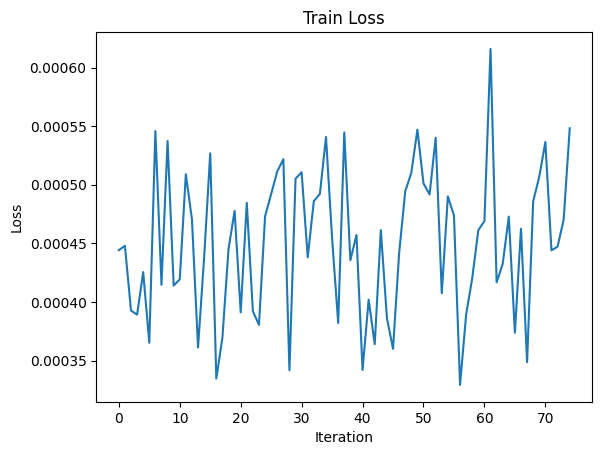

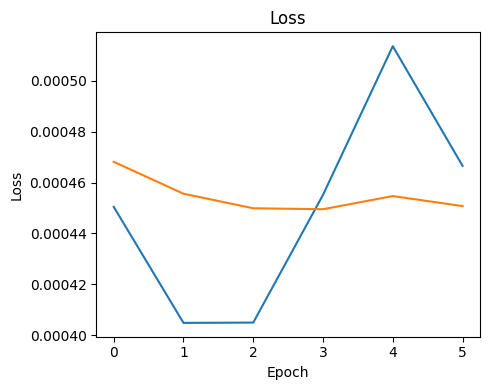

05/08/2023 09:45:18 PM | engine.py:972 Epoch[6] Complete. Time taken: 00:14:31.093


[1/75]   1%|1          [00:00<?]

05/08/2023 09:58:32 PM | engine.py:874 Engine run starting with max_epochs=1.


[1/2]  50%|#####      [00:00<?]

05/08/2023 09:59:54 PM | engine.py:972 Epoch[1] Complete. Time taken: 00:01:21.007
05/08/2023 09:59:54 PM | engine.py:988 Engine run complete. Time taken: 00:01:21.164
05/08/2023 09:59:54 PM | trainer.py:311 

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0007 / 0050 
- Training loss:   0.000445 
- Validation loss: 0.000478 
- Epoch took: 0:14:36.298622 
- Time since start: 1:44:42.365411 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to ../../trained_models/all_post_2/checkpoints/latest.model.pth. 
Output @ ../../trained_models/all_post_2 



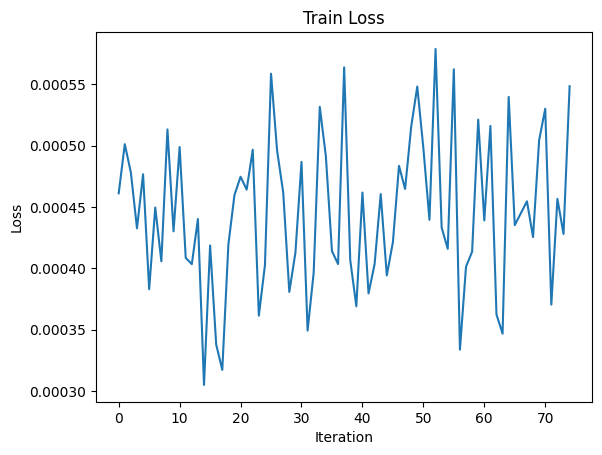

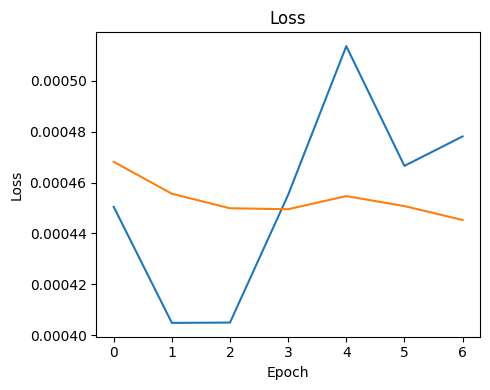

05/08/2023 09:59:54 PM | engine.py:972 Epoch[7] Complete. Time taken: 00:14:36.751
05/08/2023 10:00:03 PM | engine.py:992 Engine run is terminating due to exception: 


KeyboardInterrupt: 

In [9]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training(engine):
    plt.plot(engine.state.iter_history['loss'])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.show()
    
    data = engine.state.epoch_history
    plt.figure(figsize=(5, 4))
    plt.subplot(111)
    plt.plot(data['validation/L1Loss'], label='val')
    plt.plot(data['train/L1Loss'], label='train')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.tight_layout()
    plt.show()

trainer.run(
    train_dataloader,
    max_epochs = EPOCHS   
)

In [ ]:
separator = DeepMaskEstimationPosterior(
    nussl.AudioSignal(), None, model_path=saved_model_best,
    device=DEVICE
)
separator.model.save(saved_separator)

In [ ]:
for i, item in enumerate(test_data):
    separator.audio_signal = item['mix']
    separator.posterior = item['posterior']
    item['posterior'].to(DEVICE)
    estimates = separator()

    source_keys = list(item['sources'].keys())
    estimates = {
        'vocals': estimates[0],
        'non-vocals': item['mix'] - estimates[0]
    }

    sources = [item['sources'][k] for k in source_keys]
    estimates = [estimates[k] for k in source_keys]

    evaluator = nussl.evaluation.BSSEvalScale(
        sources, estimates, source_labels=source_keys
    )
    scores = evaluator.evaluate()
    output_file = os.path.join(eval_folder, f"{i}.json")
    with open(output_file, 'w') as f:
        json.dump(scores, f, indent=4)
    if i % 5 == 0:
        print([i], output_file) 